# Test For `DriftChecker`-`pydrift` 

We're going to test how it works with the famous titanic dataset

# Dependencies

In [1]:
import pandas as pd

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression

from pydrift import DriftChecker
from pydrift.exceptions import ColumnsNotMatchException
from pydrift.constants import PATH_DATA, RANDOM_STATE

set_config(display='diagram')

# Read Data 

In [2]:
df_titanic = pd.read_csv('../datasets/titanic.csv')

# Constants 

In [3]:
DATA_LENGTH = df_titanic.shape[0]
TARGET = 'Survived'

# Data Split

50% sample will give us a non-drift problem

We drop Ticket and Cabin features because of cardinality

In [4]:
X = df_titanic.drop(columns=['Ticket', 'Cabin', 'PassengerId', 'Name', TARGET])
y = df_titanic[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.5, random_state=RANDOM_STATE, stratify=y
)

# Test `ColumnsNotMatchException`

In [5]:
try:
    DriftChecker(X_train.drop(columns='Sex'), X_test)
except ColumnsNotMatchException as exception:
    print(exception)

Different columns for left and right dataframes

Columns in right dataframe but not in left one: Sex
Columns in left dataframe but not in right one: None


## Same With Right DataFrame 

In [6]:
try:
    DriftChecker(X_train, X_test.drop(columns='SibSp'))
except ColumnsNotMatchException as exception:
    print(exception)

Different columns for left and right dataframes

Columns in right dataframe but not in left one: None
Columns in left dataframe but not in right one: SibSp


## Both Dataframes With Different Columns 

In [7]:
try:
    DriftChecker(X_train.drop(columns='Fare'), X_test.drop(columns='Embarked'))
except ColumnsNotMatchException as exception:
    print(exception)

Different columns for left and right dataframes

Columns in right dataframe but not in left one: Fare
Columns in left dataframe but not in right one: Embarked


# Test  `ml_model_can_discriminate` Feature With Different Model

You can pass any model to be the discriminative ml model, for example a pipeline with logistic regression

In [8]:
categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder()
)

column_transformer = make_column_transformer(
    (categorical_pipeline, X_train.select_dtypes(include=['category', 'object']).columns),
    (SimpleImputer(strategy='median'), X_train.select_dtypes(include='number').columns)
)

pipeline_lr = make_pipeline(column_transformer, LogisticRegression(max_iter=1000, random_state=1994))

display(pipeline_lr)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  Index(['Sex', 'Embarked'], dtype='object')),
                                                 ('simpleimputer',
                                                  SimpleImputer(strategy='median'),
                                                  Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object'))])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=1994))])

# DiftChecker Apply

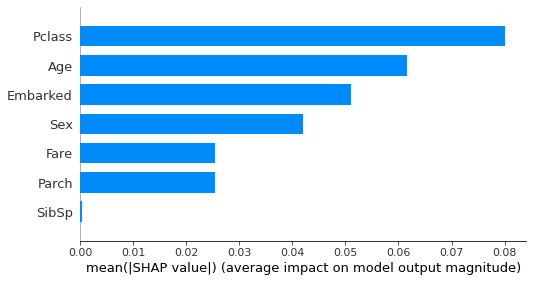

No drift found in discriminative model step

AUC drift check model: 0.50
AUC threshold: ±0.05


In [9]:
data_drift_checker_ok = DriftChecker(
    X_train, X_test
)

data_drift_checker_ok.ml_model_can_discriminate(ml_discriminate_model=pipeline_lr);

# Same But  Make It Drift

`pydrift` tells you that the problem is in `Sex` feature (as is obviously in this example)

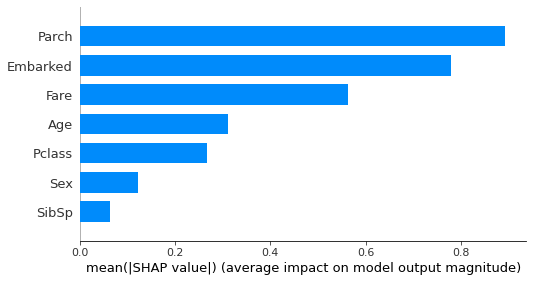

Drift found in discriminative model step, take a look on the most discriminative features (plots when minimal is set to False)

AUC drift check model: 0.82
AUC threshold: ±0.05


In [10]:
mask = (X['Pclass'] > 1) & (X['Fare'] > 10)

X_mask = X[mask]
X_unmask = X[~mask]

data_drift_checker_ko = DriftChecker(
    X_mask, X_unmask
)

data_drift_checker_ko.ml_model_can_discriminate(ml_discriminate_model=pipeline_lr);

# Using Default Discriminator With Different `auc_threshold `

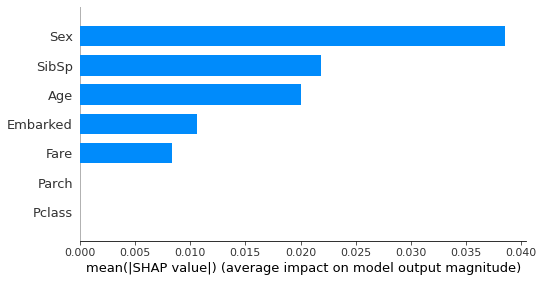

Drift found in discriminative model step, take a look on the most discriminative features (plots when minimal is set to False)

AUC drift check model: 0.46
AUC threshold: ±0.01


In [11]:
data_drift_checker_ok.ml_model_can_discriminate(auc_threshold=.01);